IBM Data Science Capstone Project

Building an Electrical Vehicle Charging Station plus Amazon Hub Locker in Calgary, Alberta, Canada


Introduction: Business Problem
The world is shifting fast towards new direction. Renewable energy and electrical vehicle are taking momentum and becoming more popular. People’s working style and lifestyle are also changed a lot by COVID-19 and we rely more and more on the online shopping. Amazon is gaining more revenue and become an inseparable part of our community.

Calgary is the largest city in Canada’s prairie provinces and capital of Canada’s energy industry. There are 1.3 million people living in Calgary. It is a vibrant city with high percentage of young people and engineers. They are willing to adopt the new lifestyle and lead the energy transition of the world.

Opening an electrical vehicle charging station plus an Amazon hub locker as a combo will be a good business idea in Calgary. It will be an important part of our community, people can work on their Amazon package while waiting for the car to be charged. Investors who grab this opportunity will be the business leader in the community as there are not many electrical vehicle charging stations and Amazon hub locker in Calgary yet.

We will use data science approach to gather information about Calgary’s communities, current gas stations, electrical charging stations and Amazon hub lockers, then we will find the optimal locations to set up business for future success. Investors interested will be willing to invest on the future business based on our research.
 
Data
1. Calgary communities data from Wikipedia. We will use web scrapper to extract useful information for us.
https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Calgary
2. Calgary’s existing gas stations. We will use FourSquare API to find gas stations in Calgary.
3. Calgary’s electrical vehicle charging station. We utilize Phantombuster to download location information from google map search. The data is saved as .csv file.
4. Calgary’s Amazon hub lockers. Phantombuster is also used. The website is
https://phantombuster.com/7908605527940361/phantoms/6696986033648658/console
5. “Geopy” library is used to get longitude and latitude information
6. “folium” library is used to create an interactive map.


In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Step 1: Find all the communities in Calgary, clean the data and only keep communities with population density over 1000 people/km2 as the potential location.

In [2]:
import requests
calgarywikipedia = requests.get("https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Calgary").text


In [3]:
conda install -c anaconda beautifulsoup4

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
from bs4 import BeautifulSoup
soup=BeautifulSoup(calgarywikipedia,'html.parser')
My_table = soup.find("table", {"class":"wikitable sortable"})

In [5]:
headings = [th.get_text().strip() for th in My_table.find("tr").find_all("th")]
datasets = []
for row in My_table.find_all("tr")[1:]:
    dataset = dict(zip(headings, (td.get_text() for td in row.find_all("td"))))
    datasets.append(dataset)
calgarydata = pd.DataFrame(datasets)
calgarydata.head()

,Name[10],Quadrant,Sector[11],Ward[12],Type[11],2012 PopulationRank,Population(2012)[10],Population(2011)[10],% change,Dwellings(2012)[10],Area(km2)[11],Populationdensity
0,Abbeydale,NE/SE,Northeast,10,Residential,82,"5,917","5,700",3.8,"2,023",1.7,"3,480.6\n"
1,Acadia,SE,South,9,Residential,27,"10,705","10,615",0.8,"5,053",3.9,"2,744.9\n"
2,Albert Park/Radisson Heights,SE,East,10,Residential,75,"6,234","6,217",0.3,"2,709",2.5,"2,493.6\n"
3,Altadore,SW,Centre,11,Residential,39,"9,116","8,907",2.3,"4,486",2.9,"3,143.4\n"
4,Alyth/Bonnybrook,SE,Centre,9,Industrial,208,16,17,−5.9,14,3.8,4.2\n


In [6]:
calgarydata.dtypes

Name[10]                object
Quadrant                object
Sector[11]              object
Ward[12]                object
Type[11]                object
2012 PopulationRank     object
Population(2012)[10]    object
Population(2011)[10]    object
% change                object
Dwellings(2012)[10]     object
Area(km2)[11]           object
Populationdensity       object
dtype: object

In [7]:
calgarydata.columns = ["Neighborhood","Quadrant","Sector","Ward","Type","2012 PopulationRank","Population 2012","Population2011","Change2011-2012","Dwellings2012","Area","Population Density"]
calgarydata=calgarydata.drop(columns=[ "Quadrant","Sector","Ward","Type","2012 PopulationRank","Population 2012","Population2011","Change2011-2012","Dwellings2012","Area" ])
calgarydata

,Neighborhood,Population Density
0,Abbeydale,"3,480.6\n"
1,Acadia,"2,744.9\n"
2,Albert Park/Radisson Heights,"2,493.6\n"
3,Altadore,"3,143.4\n"
4,Alyth/Bonnybrook,4.2\n
...,...,...
253,Windsor Park,"3,173.8\n"
254,Winston Heights/Mountview,"1,297\n"
255,Woodbine,"2,853.4\n"
256,Woodlands,"2,214.6\n"


In [8]:

calgarydata['Population Density'].replace(r'\s+|\\n', '', regex=True, inplace=True) 
calgarydata["Neighborhood"] = calgarydata["Neighborhood"].astype("string")
calgarydata['Population Density'] = calgarydata["Population Density"].astype("string")

calgarydata.dtypes

Neighborhood          string
Population Density    string
dtype: object

In [9]:
calgarydata["Population Density"][2]

'2,493.6'

In [10]:
calgarydata["Population Density"].value_counts()

0          43
—          14
            2
2,970       2
2,120       2
           ..
1,962.1     1
2,362       1
1,323.3     1
2,102.8     1
2,482       1
Name: Population Density, Length: 199, dtype: Int64

In [11]:
calgarydata["Neighborhood"][257]

<NA>

In [12]:
calgarydata=calgarydata.fillna("0")
calgarydata["Population Density"].value_counts()

0          44
—          14
            2
2,970       2
2,120       2
           ..
1,962.1     1
2,362       1
1,323.3     1
2,102.8     1
2,482       1
Name: Population Density, Length: 199, dtype: Int64

In [13]:
calgarydata=calgarydata[ calgarydata["Population Density"] != ""]
calgarydata["Population Density"].value_counts()

0          44
—          14
2,120       2
2,970       2
999.2       1
           ..
1,962.1     1
2,362       1
1,323.3     1
2,102.8     1
2,860       1
Name: Population Density, Length: 198, dtype: Int64

In [14]:
calgarydata=calgarydata[ calgarydata["Population Density"] != "—"]
calgarydata["Population Density"].value_counts()

0          44
2,970       2
2,120       2
1,387.1     1
1,007.1     1
           ..
1,428.6     1
1,962.1     1
13.5        1
4.2         1
2,165.2     1
Name: Population Density, Length: 197, dtype: Int64

In [15]:
calgarydata=calgarydata[ calgarydata["Population Density"] != "0"]
calgarydata["Population Density"].value_counts()

2,970      2
2,120      2
1,387.1    1
1,007.1    1
2,863.1    1
          ..
1,428.6    1
1,962.1    1
13.5       1
788.3      1
1,857.8    1
Name: Population Density, Length: 196, dtype: Int64

In [16]:
calgarydata["Neighborhood"].dtypes

StringDtype

In [17]:
calgarydata['Population Density']=calgarydata['Population Density'].str.replace(',','')
calgarydata["Population Density"] = calgarydata["Population Density"].astype(float)

In [18]:
calgarydata["Population Density"].dtypes

dtype('float64')

In [19]:
calgarydata= calgarydata[calgarydata["Population Density"] > 1000]
calgarydata = calgarydata.reset_index(drop=True)
calgarydata

,Neighborhood,Population Density
0,Abbeydale,3480.6
1,Acadia,2744.9
2,Albert Park/Radisson Heights,2493.6
3,Altadore,3143.4
4,Applewood Park,4061.3
...,...,...
177,Willow Park,1537.9
178,Windsor Park,3173.8
179,Winston Heights/Mountview,1297.0
180,Woodbine,2853.4


Step 2. We use “Geopy” library to get the location data for these communities and we display all of them on the map.

In [20]:
address = "Calgary, Alberta"
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
calgarylatitude = location.latitude
calgarylongitude = location.longitude
print ("Calgary's latitude and longitude is ", calgarylatitude, calgarylongitude)

Calgary's latitude and longitude is  51.0534234 -114.0625892


In [21]:
calgarydata["Latitude"] = 0.0
calgarydata["Longitude"] = 0.0
calgarydata

,Neighborhood,Population Density,Latitude,Longitude
0,Abbeydale,3480.6,0.0,0.0
1,Acadia,2744.9,0.0,0.0
2,Albert Park/Radisson Heights,2493.6,0.0,0.0
3,Altadore,3143.4,0.0,0.0
4,Applewood Park,4061.3,0.0,0.0
...,...,...,...,...
177,Willow Park,1537.9,0.0,0.0
178,Windsor Park,3173.8,0.0,0.0
179,Winston Heights/Mountview,1297.0,0.0,0.0
180,Woodbine,2853.4,0.0,0.0


In [22]:
calgarydata["Neighborhood"][26] = "Lincoln Park"
calgarydata["Neighborhood"][50] = "Douglasdale"

In [23]:

for i in calgarydata.index:
    address = calgarydata["Neighborhood"][i] + ", Calgary, Alberta"
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    calgarydata["Latitude"][i] = location.latitude
    calgarydata["Longitude"][i] = location.longitude
    
calgarydata

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhood,Population Density,Latitude,Longitude
0,Abbeydale,3480.6,51.058836,-113.929413
1,Acadia,2744.9,50.968655,-114.055587
2,Albert Park/Radisson Heights,2493.6,51.044845,-113.990195
3,Altadore,3143.4,51.015104,-114.100756
4,Applewood Park,4061.3,51.044658,-113.928931
...,...,...,...,...
177,Willow Park,1537.9,50.960293,-114.054645
178,Windsor Park,3173.8,51.006165,-114.076187
179,Winston Heights/Mountview,1297.0,51.072303,-114.047588
180,Woodbine,2853.4,50.942554,-114.128853


# Display Calgary Map based on Center point of Calgary

In [24]:
map_calgary = folium.Map(location=[calgarylatitude, calgarylongitude])
map_calgary

# Display all the community with Population Density over 1000

In [25]:
calgarydata["Latitude"]

0      51.058836
1      50.968655
2      51.044845
3      51.015104
4      51.044658
         ...    
177    50.960293
178    51.006165
179    51.072303
180    50.942554
181    50.942435
Name: Latitude, Length: 182, dtype: float64

In [26]:
import matplotlib.cm as cm
import matplotlib.colors as colors

for lat, lng, neighborhood in zip (calgarydata["Latitude"], calgarydata["Longitude"], calgarydata["Neighborhood"]):
    label = "{}".format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color="blue",
    fill=True,
    fill_color="#3186cc",
    parse_html=False).add_to(map_calgary)
       
map_calgary

Step 3. We use “FourSqaure API” to find all the gas stations in Calgary

# The following 3 lines are temporaraliy used as markdown cells to save Foursquare API resource as I am running out of quota

CLIENT_ID = "display for now"
CLIENT_SECRET = "display for now"
VERSION = "20180605"
LIMIT = 100
radius=500

print ("Your credentails: ")
print ("Client ID is", CLIENT_ID)
print ("Client Secret is", CLIENT_SECRET)

#Define getNearbyVenue function

def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

calgaryvenues = getNearbyVenues(names=calgarydata["Neighborhood"],
                                latitudes=calgarydata["Latitude"],
                                longitudes=calgarydata["Longitude"])
calgaryvenues.head()
calgaryvenues.to_csv("calgaryvenues.csv")

In [27]:
calgaryvenuelocal = pd.read_csv('calgaryvenues.csv') 
calgaryvenuelocal

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Abbeydale,51.058836,-113.929413,Atlas Pizza and Sports Bar,51.052481,-113.941859,Pizza Place
1,1,Abbeydale,51.058836,-113.929413,A&W,51.068291,-113.933571,Fast Food Restaurant
2,2,Abbeydale,51.058836,-113.929413,Costco,51.043141,-113.917518,Warehouse Store
3,3,Abbeydale,51.058836,-113.929413,Subway,51.059239,-113.934423,Sandwich Place
4,4,Abbeydale,51.058836,-113.929413,Calgary Co-op,51.068719,-113.934014,Grocery Store
...,...,...,...,...,...,...,...,...
10723,10723,Woodlands,50.942435,-114.109359,Joey's Urban,50.953461,-114.116283,Seafood Restaurant
10724,10724,Woodlands,50.942435,-114.109359,Anderson dog park,50.951951,-114.094862,Dog Run
10725,10725,Woodlands,50.942435,-114.109359,Rexal Drugs,50.949083,-114.085907,Pharmacy
10726,10726,Woodlands,50.942435,-114.109359,Ha Tien,50.953387,-114.129672,Vietnamese Restaurant


In [28]:
calgarygasstation=calgaryvenuelocal[calgaryvenuelocal["Venue Category"] == "Gas Station"]
calgarygasstation.reset_index(inplace= True, drop= True)
calgarygasstation

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,6,Abbeydale,51.058836,-113.929413,Petro-Canada,51.069370,-113.933826,Gas Station
1,76,Acadia,50.968655,-114.055587,Petro-Canada,50.963716,-114.058331,Gas Station
2,97,Acadia,50.968655,-114.055587,Petro-Canada,50.969694,-114.070863,Gas Station
3,178,Albert Park/Radisson Heights,51.044845,-113.990195,Husky,51.058815,-114.000803,Gas Station
4,210,Altadore,51.015104,-114.100756,Petro-Canada,51.023761,-114.113538,Gas Station
...,...,...,...,...,...,...,...,...
255,10486,Willow Park,50.960293,-114.054645,Petro-Canada,50.963716,-114.058331,Gas Station
256,10510,Willow Park,50.960293,-114.054645,Petro-Canada,50.969694,-114.070863,Gas Station
257,10614,Windsor Park,51.006165,-114.076187,Shell,50.991697,-114.063482,Gas Station
258,10615,Windsor Park,51.006165,-114.076187,Esso,50.992672,-114.072257,Gas Station


In [29]:
calgarygasstation.groupby("Neighborhood")["Venue"].count()

Neighborhood
Abbeydale                       1
Acadia                          2
Albert Park/Radisson Heights    1
Altadore                        1
Arbour Lake                     5
                               ..
Westgate                        1
Whitehorn                       3
Willow Park                     2
Windsor Park                    2
Winston Heights/Mountview       1
Name: Venue, Length: 125, dtype: int64

In [30]:
gasstationcount = calgarygasstation.groupby("Neighborhood").count()
gasstationcount["Number of gas station"] = gasstationcount["Venue"]
gasstationcount=pd.DataFrame(gasstationcount["Number of gas station"])
gasstationcount

,Number of gas station
Neighborhood,
Abbeydale,1
Acadia,2
Albert Park/Radisson Heights,1
Altadore,1
Arbour Lake,5
...,...
Westgate,1
Whitehorn,3
Willow Park,2


<AxesSubplot:xlabel='Neighborhood'>

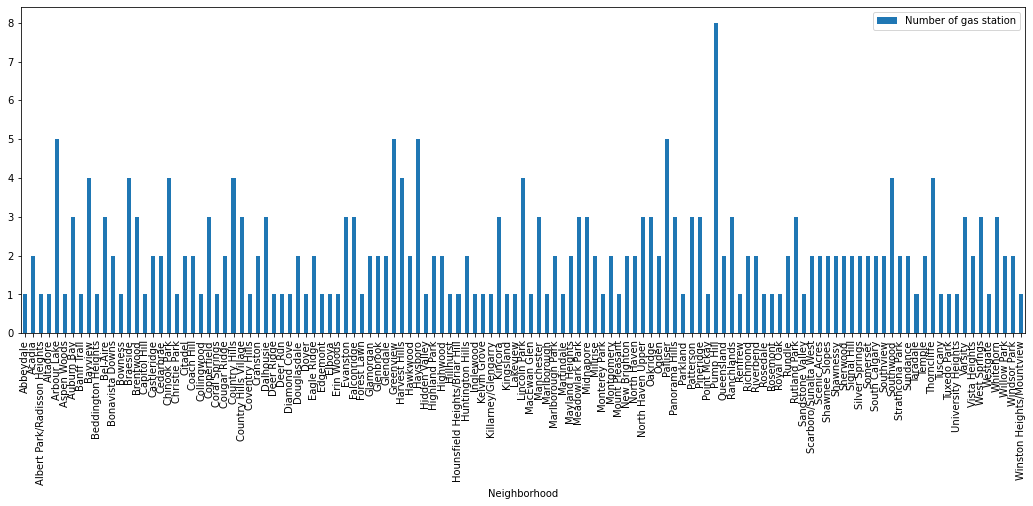

In [31]:
gasstationcount.plot.bar(figsize=(18,6))

In [32]:
gasstationcount["Number of gas station"].value_counts()

1    46
2    44
3    22
4     8
5     4
8     1
Name: Number of gas station, dtype: int64

In [33]:
targetcommunity = gasstationcount[gasstationcount ["Number of gas station"] > 3 ]
targetcommunity = targetcommunity.reset_index()


In [34]:
neighborhoodlist = targetcommunity["Neighborhood"].tolist()
neighborhoodlist

['Arbour Lake',
 'Bayview',
 'Braeside',
 'Chinook Park',
 'Country Hills',
 'Greenview',
 'Harvest Hills',
 'Haysboro',
 'Lincoln Park',
 'Palliser',
 'Pump Hill',
 'Southwood',
 'Thorncliffe']

In [35]:
calgarydata["Decision"] = "option"
for i in calgarydata.index:
    if calgarydata["Neighborhood"][i] in neighborhoodlist:
        calgarydata["Decision"][i] = "Keep"
    else:
        calgarydata["Decision"][i] = "Delete"
        


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
calgaryshortlist= calgarydata[calgarydata["Decision"] == "Keep"]
calgaryshortlist.reset_index(inplace= True, drop=True)
calgaryshortlist=calgaryshortlist.drop(9)
calgaryshortlist

,Neighborhood,Population Density,Latitude,Longitude,Decision
0,Arbour Lake,2462.7,51.136786,-114.202355,Keep
1,Bayview,1705.0,50.973577,-114.112561,Keep
2,Braeside,2970.0,50.955784,-114.106816,Keep
3,Lincoln Park,4932.5,51.009168,-114.129843,Keep
4,Chinook Park,2845.0,50.983123,-114.089301,Keep
5,Country Hills,1962.1,51.143001,-114.078536,Keep
6,Greenview,3950.0,51.095382,-114.058469,Keep
7,Harvest Hills,3364.5,51.148198,-114.053778,Keep
8,Haysboro,2571.5,50.973967,-114.085193,Keep
10,Palliser,3293.0,50.967469,-114.110772,Keep


Step 4. We extra google map data to find existing electrical vehichle charging station and Amazon hub lockers from third part API and saved as .csv file, these are the places that we should keep certaian distance to avoid competition. The electrical charging station and Amazon hub locker are listed below: 

In [37]:
ElectricalplusAmazon=pd.read_csv("Electrical Vehicle Charge Station Plus Amazon Hub Locker in Calgary.csv")
ElectricalplusAmazon=ElectricalplusAmazon[["title","address","latitude","longitude"]]
ElectricalplusAmazon=ElectricalplusAmazon.drop(23)
ElectricalplusAmazon

,title,address,latitude,longitude
0,ChargePoint Charging Station,"11527 29 St SE, Calgary, AB T2Z 0N4, Canada",50.949562,-113.997687
1,Tesla Supercharger,"261055 Crossiron Blvd, Rocky View County, AB T...",51.203562,-113.989688
2,Flo Charging Station,"933-33 Heritage Meadows Way SE, Calgary, AB T2...",50.980812,-114.039687
3,Flo Charging Station,"7137 16 Ave NW, Calgary, AB T3B 2S6, Canada",51.078187,-114.195688
4,Flo Charging Station,"192 Stewart Green SW, Calgary, AB T3H 3C8, Canada",51.015687,-114.166938
5,Flo Charging Station,"135 Southland Dr SE, Calgary, AB T2J 5X5, Canada",50.964188,-114.068687
6,ChargePoint Charging Station,"2620 A Barlow Trail NE, Calgary, AB T1Y 1A1, C...",51.076188,-114.000313
7,ChargePoint Charging Station,"34 Heritage Meadows Rd, Calgary, AB T2H 3C1, C...",50.985188,-114.032938
8,Electric Vehicle Charging Station,"5940 Blackfoot Trail SE, Calgary, AB T2H 2B5, ...",51.000813,-114.047062
9,Tesla Destination Charger,"11 Freeport Cres NE, Calgary, AB T3J 0T4, Canada",51.140563,-114.025688


In [38]:
ElectricalplusAmazon["latitude"][0]
ElectricalplusAmazon["longitude"][0]

-113.9976875

In [39]:
ElectricalplusAmazon["latitude"][1]
ElectricalplusAmazon["longitude"][1]

-113.9896875

In [40]:
Avoidlist=ElectricalplusAmazon["address"].tolist()
Avoidlist

['11527 29 St SE, Calgary, AB T2Z 0N4, Canada',
 '261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada',
 '933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada',
 '7137 16 Ave NW, Calgary, AB T3B 2S6, Canada',
 '192 Stewart Green SW, Calgary, AB T3H 3C8, Canada',
 '135 Southland Dr SE, Calgary, AB T2J 5X5, Canada',
 '2620 A Barlow Trail NE, Calgary, AB T1Y 1A1, Canada',
 '34 Heritage Meadows Rd, Calgary, AB T2H 3C1, Canada',
 '5940 Blackfoot Trail SE, Calgary, AB T2H 2B5, Canada',
 '11 Freeport Cres NE, Calgary, AB T3J 0T4, Canada',
 '123 Freeport Blvd NE, Calgary, AB T3N 0A3, Canada',
 '1316 33 St NE, Calgary, AB T2A 6J4, Canada',
 'Edgefield St, Strathmore, AB T0J 1Y0, Canada',
 '6455 Macleod Trail SW, Calgary, AB T2H 0K8, Canada',
 '7121 107 Ave SE, Calgary, AB T2C 4Z8, Canada',
 '225 6 Ave SW, Calgary, AB T2P 1N2, Canada',
 '727 1 St SE, Calgary, AB T2G 0K7, Canada',
 '322 9 Ave SE, Calgary, AB T2G 5A6, Canada',
 '100 Ranch Market, Strathmore, AB T1P 0A8, Canada',
 '

Step 5: We need to find the distance between each target community and each avoid location. Thus we need to create a distance matrix as follow:

In [41]:
for i in Avoidlist:
    calgaryshortlist[i] = 0.0

calgaryshortlist

,Neighborhood,Population Density,Latitude,Longitude,Decision,"11527 29 St SE, Calgary, AB T2Z 0N4, Canada","261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada","933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada","7137 16 Ave NW, Calgary, AB T3B 2S6, Canada","192 Stewart Green SW, Calgary, AB T3H 3C8, Canada",...,"620 6 Ave SE, Calgary, AB T2G 0G1, Canada","110 9 Ave SE, Calgary, AB T2G 5A6, Canada","5222 Macleod Trail, Calgary, AB T2H 0J2, Canada","4880 32 Ave NW Calgary AB T3A 4N7 32 Ave NW, Calgary, AB T3A 4N7, Canada","205 5 Ave SW, Calgary, AB T2P 2V7, Canada","at ON the RUN, 2315 68 St NE, Calgary, AB T1Y 6S4, Canada","at PHARMASAVE, 3803 26 Ave SW, Calgary, AB T3E 6V7, Canada","at PHARMASAVE, 222-15566 McIvor Blvd SE, Calgary, AB T2Z 4Y2, Canada","at #1 Convenience Store, 10015 Oakfield Dr SW #1, Calgary, AB T2V 1S9, Canada","at Amble Ventures, 825 8 Ave SW, Calgary, AB T2P 2T3, Canada"
0,Arbour Lake,2462.7,51.136786,-114.202355,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bayview,1705.0,50.973577,-114.112561,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Braeside,2970.0,50.955784,-114.106816,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Lincoln Park,4932.5,51.009168,-114.129843,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Chinook Park,2845.0,50.983123,-114.089301,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Country Hills,1962.1,51.143001,-114.078536,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Greenview,3950.0,51.095382,-114.058469,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Harvest Hills,3364.5,51.148198,-114.053778,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Haysboro,2571.5,50.973967,-114.085193,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Palliser,3293.0,50.967469,-114.110772,Keep,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
calgaryshortlist.columns

Index(['Neighborhood', 'Population Density', 'Latitude', 'Longitude',
       'Decision', '11527 29 St SE, Calgary, AB T2Z 0N4, Canada',
       '261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada',
       '933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada',
       '7137 16 Ave NW, Calgary, AB T3B 2S6, Canada',
       '192 Stewart Green SW, Calgary, AB T3H 3C8, Canada',
       '135 Southland Dr SE, Calgary, AB T2J 5X5, Canada',
       '2620 A Barlow Trail NE, Calgary, AB T1Y 1A1, Canada',
       '34 Heritage Meadows Rd, Calgary, AB T2H 3C1, Canada',
       '5940 Blackfoot Trail SE, Calgary, AB T2H 2B5, Canada',
       '11 Freeport Cres NE, Calgary, AB T3J 0T4, Canada',
       '123 Freeport Blvd NE, Calgary, AB T3N 0A3, Canada',
       '1316 33 St NE, Calgary, AB T2A 6J4, Canada',
       'Edgefield St, Strathmore, AB T0J 1Y0, Canada',
       '6455 Macleod Trail SW, Calgary, AB T2H 0K8, Canada',
       '7121 107 Ave SE, Calgary, AB T2C 4Z8, Canada',
       '225 6 Ave SW

In [43]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [44]:
import haversine as hs

def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)


In [45]:
avoid = '261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada'

a = ElectricalplusAmazon[ElectricalplusAmazon["address"] == avoid].latitude
b = ElectricalplusAmazon[ElectricalplusAmazon["address"] == avoid].longitude
locavoid= (a,b)
print(locavoid)

target = "Lincoln Park"
c = calgaryshortlist[calgaryshortlist["Neighborhood"] == target].Latitude
d = calgaryshortlist[calgaryshortlist["Neighborhood"] == target].Longitude
locneighborhood= (c,d)
print(locneighborhood)

result = distance_from(locavoid, locneighborhood)
print("distance is", result, "km")

(1    51.203562
Name: latitude, dtype: float64, 1   -113.989688
Name: longitude, dtype: float64)
(3    51.009168
Name: Latitude, dtype: float64, 3   -114.129843
Name: Longitude, dtype: float64)
distance is 23.73 km


In [46]:
index = calgaryshortlist.index
specificindex = index [calgaryshortlist['Neighborhood']=="Southwood"]
print(specificindex)
print(calgaryshortlist["Neighborhood"][specificindex])

Int64Index([12], dtype='int64')
12    Southwood
Name: Neighborhood, dtype: string


In [47]:
for avoid in Avoidlist:
        a = ElectricalplusAmazon[ElectricalplusAmazon["address"] == avoid].latitude
        b = ElectricalplusAmazon[ElectricalplusAmazon["address"] == avoid].longitude
        locavoid= (a,b)
        print (avoid, a)

11527 29 St SE, Calgary, AB T2Z 0N4, Canada 0    50.949562
Name: latitude, dtype: float64
261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada 1    51.203562
Name: latitude, dtype: float64
933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada 2    50.980812
Name: latitude, dtype: float64
7137 16 Ave NW, Calgary, AB T3B 2S6, Canada 3    51.078187
Name: latitude, dtype: float64
192 Stewart Green SW, Calgary, AB T3H 3C8, Canada 4    51.015687
Name: latitude, dtype: float64
135 Southland Dr SE, Calgary, AB T2J 5X5, Canada 5    50.964188
Name: latitude, dtype: float64
2620 A Barlow Trail NE, Calgary, AB T1Y 1A1, Canada 6    51.076188
Name: latitude, dtype: float64
34 Heritage Meadows Rd, Calgary, AB T2H 3C1, Canada 7    50.985188
Name: latitude, dtype: float64
5940 Blackfoot Trail SE, Calgary, AB T2H 2B5, Canada 8    51.000813
Name: latitude, dtype: float64
11 Freeport Cres NE, Calgary, AB T3J 0T4, Canada 9    51.140563
Name: latitude, dtype: float64
123 Freeport Blvd NE, Calg

In [48]:
index = calgaryshortlist.index
for target in calgaryshortlist["Neighborhood"]:
    for avoid in Avoidlist:
        a = ElectricalplusAmazon[ElectricalplusAmazon["address"] == avoid].latitude
        b = ElectricalplusAmazon[ElectricalplusAmazon["address"] == avoid].longitude
        locavoid= (a,b)
        c = calgaryshortlist[calgaryshortlist["Neighborhood"] == target].Latitude
        d = calgaryshortlist[calgaryshortlist["Neighborhood"] == target].Longitude
        locneighborhood= (c,d)
        
        specificindex = index [calgaryshortlist['Neighborhood'] == target]
        result = distance_from(locavoid, locneighborhood)
        calgaryshortlist[avoid][specificindex]=result
        
    print(target , "is done")
        
        

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Arbour Lake is done
Bayview is done
Braeside is done
Lincoln Park is done
Chinook Park is done
Country Hills is done
Greenview is done
Harvest Hills is done
Haysboro is done
Palliser is done
Pump Hill is done
Southwood is done
Thorncliffe is done


In [49]:
calgaryshortlist

,Neighborhood,Population Density,Latitude,Longitude,Decision,"11527 29 St SE, Calgary, AB T2Z 0N4, Canada","261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada","933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada","7137 16 Ave NW, Calgary, AB T3B 2S6, Canada","192 Stewart Green SW, Calgary, AB T3H 3C8, Canada",...,"620 6 Ave SE, Calgary, AB T2G 0G1, Canada","110 9 Ave SE, Calgary, AB T2G 5A6, Canada","5222 Macleod Trail, Calgary, AB T2H 0J2, Canada","4880 32 Ave NW Calgary AB T3A 4N7 32 Ave NW, Calgary, AB T3A 4N7, Canada","205 5 Ave SW, Calgary, AB T2P 2V7, Canada","at ON the RUN, 2315 68 St NE, Calgary, AB T1Y 6S4, Canada","at PHARMASAVE, 3803 26 Ave SW, Calgary, AB T3E 6V7, Canada","at PHARMASAVE, 222-15566 McIvor Blvd SE, Calgary, AB T2Z 4Y2, Canada","at #1 Convenience Store, 10015 Oakfield Dr SW #1, Calgary, AB T2V 1S9, Canada","at Amble Ventures, 825 8 Ave SW, Calgary, AB T2P 2T3, Canada"
0,Arbour Lake,2462.7,51.136786,-114.202355,Keep,25.26,16.58,20.74,6.53,13.69,...,14.60,14.13,17.14,6.84,13.75,19.92,12.64,30.50,20.03,13.23
1,Bayview,1705.0,50.973577,-114.112561,Keep,8.48,26.97,5.17,13.00,6.03,...,9.32,8.66,4.92,12.50,8.87,16.60,6.57,13.22,1.92,8.32
2,Braeside,2970.0,50.955784,-114.106816,Keep,7.68,28.74,5.46,14.96,7.88,...,10.94,10.37,6.39,14.52,10.61,17.71,8.57,11.96,1.96,10.16
3,Lincoln Park,4932.5,51.009168,-114.129843,Keep,11.38,23.73,7.05,8.95,2.69,...,7.05,6.15,4.33,8.37,6.20,15.33,2.43,16.51,5.24,5.33
4,Chinook Park,2845.0,50.983123,-114.089301,Keep,7.42,25.48,3.48,12.93,6.53,...,7.67,7.11,3.13,12.00,7.36,14.69,6.35,12.48,3.85,6.98
5,Country Hills,1962.1,51.143001,-114.078536,Keep,22.24,9.15,18.24,10.90,15.45,...,10.83,10.97,15.05,8.60,10.64,12.64,13.35,27.11,20.48,10.82
6,Greenview,3950.0,51.095382,-114.058469,Keep,16.76,12.95,12.81,9.77,11.66,...,5.38,5.63,9.76,6.94,5.33,8.92,9.34,21.65,15.71,5.74
7,Harvest Hills,3364.5,51.148198,-114.053778,Keep,22.43,7.61,18.64,12.60,16.72,...,11.22,11.51,15.64,10.18,11.21,11.73,14.54,27.14,21.42,11.55
8,Haysboro,2571.5,50.973967,-114.085193,Keep,6.70,26.39,3.28,13.93,7.37,...,8.53,8.03,3.95,13.06,8.31,15.20,7.35,11.63,3.60,7.98
10,Palliser,3293.0,50.967469,-114.110772,Keep,8.17,27.58,5.19,13.67,6.65,...,9.86,9.23,5.40,13.19,9.46,16.98,7.25,12.77,1.66,8.95


In [50]:
calgaryshortlist["mindistance"] = 0.0
for i in calgaryshortlist.index:
    calgaryshortlist["mindistance"][i] = calgaryshortlist.loc[i, Avoidlist].min()
    print (calgaryshortlist.loc[i, Avoidlist].min())

6.53
1.92
1.96
2.43
1.38
3.7
4.59
2.14
1.52
1.66
2.16
1.31
4.9


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
calgaryshortlist

,Neighborhood,Population Density,Latitude,Longitude,Decision,"11527 29 St SE, Calgary, AB T2Z 0N4, Canada","261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada","933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada","7137 16 Ave NW, Calgary, AB T3B 2S6, Canada","192 Stewart Green SW, Calgary, AB T3H 3C8, Canada",...,"110 9 Ave SE, Calgary, AB T2G 5A6, Canada","5222 Macleod Trail, Calgary, AB T2H 0J2, Canada","4880 32 Ave NW Calgary AB T3A 4N7 32 Ave NW, Calgary, AB T3A 4N7, Canada","205 5 Ave SW, Calgary, AB T2P 2V7, Canada","at ON the RUN, 2315 68 St NE, Calgary, AB T1Y 6S4, Canada","at PHARMASAVE, 3803 26 Ave SW, Calgary, AB T3E 6V7, Canada","at PHARMASAVE, 222-15566 McIvor Blvd SE, Calgary, AB T2Z 4Y2, Canada","at #1 Convenience Store, 10015 Oakfield Dr SW #1, Calgary, AB T2V 1S9, Canada","at Amble Ventures, 825 8 Ave SW, Calgary, AB T2P 2T3, Canada",mindistance
0,Arbour Lake,2462.7,51.136786,-114.202355,Keep,25.26,16.58,20.74,6.53,13.69,...,14.13,17.14,6.84,13.75,19.92,12.64,30.50,20.03,13.23,6.53
1,Bayview,1705.0,50.973577,-114.112561,Keep,8.48,26.97,5.17,13.00,6.03,...,8.66,4.92,12.50,8.87,16.60,6.57,13.22,1.92,8.32,1.92
2,Braeside,2970.0,50.955784,-114.106816,Keep,7.68,28.74,5.46,14.96,7.88,...,10.37,6.39,14.52,10.61,17.71,8.57,11.96,1.96,10.16,1.96
3,Lincoln Park,4932.5,51.009168,-114.129843,Keep,11.38,23.73,7.05,8.95,2.69,...,6.15,4.33,8.37,6.20,15.33,2.43,16.51,5.24,5.33,2.43
4,Chinook Park,2845.0,50.983123,-114.089301,Keep,7.42,25.48,3.48,12.93,6.53,...,7.11,3.13,12.00,7.36,14.69,6.35,12.48,3.85,6.98,1.38
5,Country Hills,1962.1,51.143001,-114.078536,Keep,22.24,9.15,18.24,10.90,15.45,...,10.97,15.05,8.60,10.64,12.64,13.35,27.11,20.48,10.82,3.70
6,Greenview,3950.0,51.095382,-114.058469,Keep,16.76,12.95,12.81,9.77,11.66,...,5.63,9.76,6.94,5.33,8.92,9.34,21.65,15.71,5.74,4.59
7,Harvest Hills,3364.5,51.148198,-114.053778,Keep,22.43,7.61,18.64,12.60,16.72,...,11.51,15.64,10.18,11.21,11.73,14.54,27.14,21.42,11.55,2.14
8,Haysboro,2571.5,50.973967,-114.085193,Keep,6.70,26.39,3.28,13.93,7.37,...,8.03,3.95,13.06,8.31,15.20,7.35,11.63,3.60,7.98,1.52
10,Palliser,3293.0,50.967469,-114.110772,Keep,8.17,27.58,5.19,13.67,6.65,...,9.23,5.40,13.19,9.46,16.98,7.25,12.77,1.66,8.95,1.66


In [52]:
calgaryshortlist["Decision"] = "Undecided"
for i in calgaryshortlist.index:
    if calgaryshortlist["mindistance"][i] > 3.5:
        calgaryshortlist["Decision"][i] = "Yes"
    else:
        calgaryshortlist["Decision"][i] = "No"

calgaryshortlist

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhood,Population Density,Latitude,Longitude,Decision,"11527 29 St SE, Calgary, AB T2Z 0N4, Canada","261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada","933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada","7137 16 Ave NW, Calgary, AB T3B 2S6, Canada","192 Stewart Green SW, Calgary, AB T3H 3C8, Canada",...,"110 9 Ave SE, Calgary, AB T2G 5A6, Canada","5222 Macleod Trail, Calgary, AB T2H 0J2, Canada","4880 32 Ave NW Calgary AB T3A 4N7 32 Ave NW, Calgary, AB T3A 4N7, Canada","205 5 Ave SW, Calgary, AB T2P 2V7, Canada","at ON the RUN, 2315 68 St NE, Calgary, AB T1Y 6S4, Canada","at PHARMASAVE, 3803 26 Ave SW, Calgary, AB T3E 6V7, Canada","at PHARMASAVE, 222-15566 McIvor Blvd SE, Calgary, AB T2Z 4Y2, Canada","at #1 Convenience Store, 10015 Oakfield Dr SW #1, Calgary, AB T2V 1S9, Canada","at Amble Ventures, 825 8 Ave SW, Calgary, AB T2P 2T3, Canada",mindistance
0,Arbour Lake,2462.7,51.136786,-114.202355,Yes,25.26,16.58,20.74,6.53,13.69,...,14.13,17.14,6.84,13.75,19.92,12.64,30.50,20.03,13.23,6.53
1,Bayview,1705.0,50.973577,-114.112561,No,8.48,26.97,5.17,13.00,6.03,...,8.66,4.92,12.50,8.87,16.60,6.57,13.22,1.92,8.32,1.92
2,Braeside,2970.0,50.955784,-114.106816,No,7.68,28.74,5.46,14.96,7.88,...,10.37,6.39,14.52,10.61,17.71,8.57,11.96,1.96,10.16,1.96
3,Lincoln Park,4932.5,51.009168,-114.129843,No,11.38,23.73,7.05,8.95,2.69,...,6.15,4.33,8.37,6.20,15.33,2.43,16.51,5.24,5.33,2.43
4,Chinook Park,2845.0,50.983123,-114.089301,No,7.42,25.48,3.48,12.93,6.53,...,7.11,3.13,12.00,7.36,14.69,6.35,12.48,3.85,6.98,1.38
5,Country Hills,1962.1,51.143001,-114.078536,Yes,22.24,9.15,18.24,10.90,15.45,...,10.97,15.05,8.60,10.64,12.64,13.35,27.11,20.48,10.82,3.70
6,Greenview,3950.0,51.095382,-114.058469,Yes,16.76,12.95,12.81,9.77,11.66,...,5.63,9.76,6.94,5.33,8.92,9.34,21.65,15.71,5.74,4.59
7,Harvest Hills,3364.5,51.148198,-114.053778,No,22.43,7.61,18.64,12.60,16.72,...,11.51,15.64,10.18,11.21,11.73,14.54,27.14,21.42,11.55,2.14
8,Haysboro,2571.5,50.973967,-114.085193,No,6.70,26.39,3.28,13.93,7.37,...,8.03,3.95,13.06,8.31,15.20,7.35,11.63,3.60,7.98,1.52
10,Palliser,3293.0,50.967469,-114.110772,No,8.17,27.58,5.19,13.67,6.65,...,9.23,5.40,13.19,9.46,16.98,7.25,12.77,1.66,8.95,1.66


In [53]:
map_calgary = folium.Map(location=[calgarylatitude, calgarylongitude])


for lat, lng, neighborhood, decision in zip (calgaryshortlist["Latitude"], calgaryshortlist["Longitude"], calgaryshortlist["Neighborhood"],calgaryshortlist["Decision"]):
    label = "{}, {}".format(neighborhood, decision)
    label = folium.Popup(label, parse_html=True)
    
    if decision == "Yes":
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="Green",
        fill=True,
        fill_color="#3186cc",
        parse_html=False).add_to(map_calgary)
    
    else:
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="black",
        fill=True,
        fill_color="#3186cc",
        parse_html=False).add_to(map_calgary)
    
map_calgary

In [54]:
for lat, lng, address, title in zip (ElectricalplusAmazon["latitude"], ElectricalplusAmazon["longitude"], ElectricalplusAmazon["address"], ElectricalplusAmazon["title"]):
    label = "{}".format(address)
    label = folium.Popup(label, parse_html=True)
    
    if "Amazon" in title:
        folium.Circle(
        [lat, lng],
        radius=3500,
        popup=label,
        color="Red",
        fill=False,
        fill_color="#3186cc",
        parse_html=False).add_to(map_calgary)
        
    else:
        folium.Circle(
        [lat, lng],
        radius=3500,
        popup=label,
        color="Blue",
        fill=False,
        fill_color="#3186cc",
        parse_html=False).add_to(map_calgary)
        
map_calgary

#Results 

In [55]:
calgaryshortlist[calgaryshortlist["mindistance"] > 3.5]

,Neighborhood,Population Density,Latitude,Longitude,Decision,"11527 29 St SE, Calgary, AB T2Z 0N4, Canada","261055 Crossiron Blvd, Rocky View County, AB T4A 0G3, Canada","933-33 Heritage Meadows Way SE, Calgary, AB T2H 3B8, Canada","7137 16 Ave NW, Calgary, AB T3B 2S6, Canada","192 Stewart Green SW, Calgary, AB T3H 3C8, Canada",...,"110 9 Ave SE, Calgary, AB T2G 5A6, Canada","5222 Macleod Trail, Calgary, AB T2H 0J2, Canada","4880 32 Ave NW Calgary AB T3A 4N7 32 Ave NW, Calgary, AB T3A 4N7, Canada","205 5 Ave SW, Calgary, AB T2P 2V7, Canada","at ON the RUN, 2315 68 St NE, Calgary, AB T1Y 6S4, Canada","at PHARMASAVE, 3803 26 Ave SW, Calgary, AB T3E 6V7, Canada","at PHARMASAVE, 222-15566 McIvor Blvd SE, Calgary, AB T2Z 4Y2, Canada","at #1 Convenience Store, 10015 Oakfield Dr SW #1, Calgary, AB T2V 1S9, Canada","at Amble Ventures, 825 8 Ave SW, Calgary, AB T2P 2T3, Canada",mindistance
0,Arbour Lake,2462.7,51.136786,-114.202355,Yes,25.26,16.58,20.74,6.53,13.69,...,14.13,17.14,6.84,13.75,19.92,12.64,30.50,20.03,13.23,6.53
5,Country Hills,1962.1,51.143001,-114.078536,Yes,22.24,9.15,18.24,10.90,15.45,...,10.97,15.05,8.60,10.64,12.64,13.35,27.11,20.48,10.82,3.70
6,Greenview,3950.0,51.095382,-114.058469,Yes,16.76,12.95,12.81,9.77,11.66,...,5.63,9.76,6.94,5.33,8.92,9.34,21.65,15.71,5.74,4.59
13,Thorncliffe,2634.2,51.106096,-114.069411,Yes,18.11,12.18,14.08,9.35,12.15,...,6.83,10.93,6.56,6.50,10.03,9.89,23.04,16.62,6.76,4.90
